# <center> Generative adversarial network (GAN) </center>
<center><h2> 1.Training Discriminator </h2></center>
<img src="http://drive.google.com/uc?export=view&id=18HIBQFUXjtWqu364u6i3LFwuZTCt-29w">
<br>
<center><h2> 2.Training Generator </h2></center>    
<img src="http://drive.google.com/uc?export=view&id=1aHEGLTWmH6iPqk2YUnmNYwFEMBSS7hwp">

```
참고자료
Deep Learning with Python, 2017, François Chollet (케라스 창시자에게 배우는 딥러닝, 8장)

코드참고 
https://www.youtube.com/watch?v=T-MCludVNn4
https://github.com/rickiepark/deep-learning-with-python-notebooks/
http://www.somanet.xyz/2017/06/blog-post_21.html (구글드라이브 이미지 공유방법)

작성자: 19/07/13 김도완
```

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all-dogs', 'annotation']


In [2]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

#ROOT = '../input/generative-dog-images/'
ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 
print(len(IMAGES))
print(len(breeds))

20579
120


In [3]:
idxIn = 0
namesIn = []
imagesIn = np.zeros((25000,64,64,3))

In [4]:
# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds

for breed in breeds:
    for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):        
        try: 
            img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg')            
        except: 
            continue        
        tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            #if idxIn%1000==0: print(idxIn)
            namesIn.append(breed)
            idxIn += 1

# shuffle            
idx = np.arange(idxIn)
np.random.shuffle(idx)
imagesIn = imagesIn[idx,:,:,:]
namesIn = np.array(namesIn)[idx]   

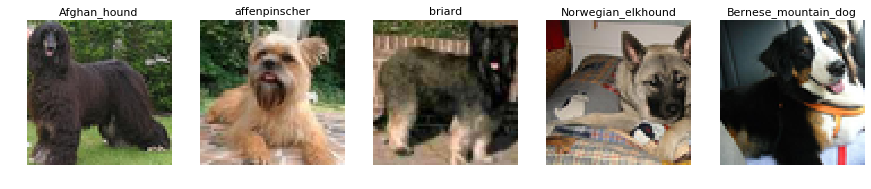

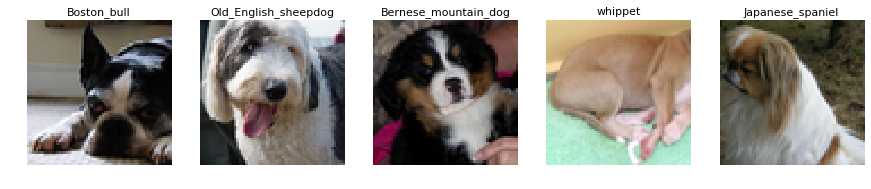

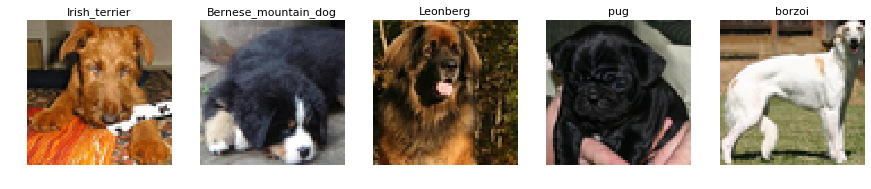

In [5]:
# DISPLAY CROPPED IMAGES

x = np.random.randint(0,idxIn,25)
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [6]:
print(namesIn.shape)
print(imagesIn.shape)

(22125,)
(22125, 64, 64, 3)


In [7]:
from keras.layers import Input, Reshape, Dropout, Dense, Flatten
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from tqdm import tqdm

Using TensorFlow backend.


In [8]:


GENERATE_RES = 2 # (1=32, 2=64, 3=96, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square) #64*64
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 5
PREVIEW_MARGIN = 16
SAVE_FREQ = 100

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
# DATA_PATH = '/content/drive/My Drive/projects/faces'
EPOCHS = 10000
BATCH_SIZE = 32

In [9]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(Activation('relu'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    #model.add(Activation('relu'))
    model.add(LeakyReLU(alpha=0.2))
   
    # Output resolution, additional upsampling
    for i in range(GENERATE_RES):
        model.add(UpSampling2D())
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Activation('relu'))
        model.add(LeakyReLU(alpha=0.2))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    input = Input(shape=(seed_size,))
    generated_image = model(input)

    return Model(input,generated_image)

In [10]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    input_image = Input(shape=image_shape)

    validity = model(input_image)

    return Model(input_image, validity)

In [11]:
def save_images(cnt,noise):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
    
    generated_images = generator.predict(noise)
    #generated_images = 0.5 * generated_images + 0.5
    
    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
            image_count += 1
            
    output_path = "./train_ouput" #output
    if not os.path.exists(output_path):
        os.makedirs(output_path)            
    
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

    # image view    
    plt.figure(figsize=(10,5))
    plt.axis('off')
    plt.imshow(im)
    plt.show()



In [12]:
# 판별자 학습모델
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
optimizer = Adam(1.5e-4,0.5) # learning rate and momentum adjusted from paper

discriminator = build_discriminator(image_shape)
discriminator.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
generator = build_generator(SEED_SIZE,IMAGE_CHANNELS)

# 생성자 학습모델 # 학습속도가 느림, 판별자와 학습률 구분설정
random_input = Input(shape=(SEED_SIZE,))

generated_image = generator(random_input)

discriminator.trainable = False

validity = discriminator(generated_image)

combined = Model(random_input,validity)
combined.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])

In [13]:
import os
from keras.preprocessing import image

x_train= imagesIn
print(x_train.shape)

# 데이터를 정규화합니다.(minmax scale)
x_train = x_train.reshape((x_train.shape[0],) + (64, 64, 3)).astype('float32') / 255
print(x_train.shape)

(22125, 64, 64, 3)
(22125, 64, 64, 3)


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


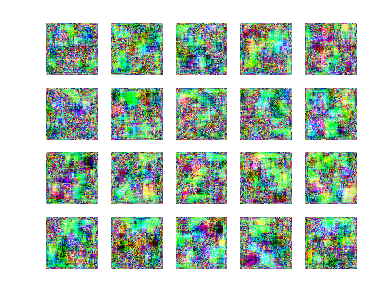

Epoch 0, Discriminator accuarcy: 0.171875, Generator accuracy: 0.84375


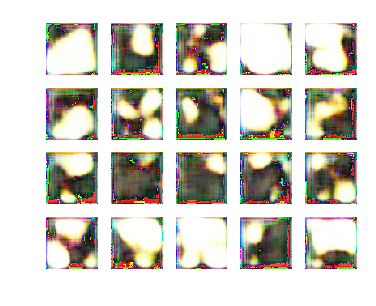

Epoch 100, Discriminator accuarcy: 0.234375, Generator accuracy: 0.15625


In [14]:
y_real = np.ones((BATCH_SIZE,1)) # 레이블 1 진짜
y_fake = np.zeros((BATCH_SIZE,1)) # 레이블 0 가짜


fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))

cnt = 1
EPOCHS = 200 # 30000

for epoch in range(EPOCHS):
    idx = np.random.randint(0,x_train.shape[0],BATCH_SIZE)
    x_real = x_train[idx]

    # Generate some images
    seed = np.random.normal(0,1,(BATCH_SIZE,SEED_SIZE))
    x_fake = generator.predict(seed)
    
    # 레이블에 노이즈를 넣는다.
    y_real_noise = np.ones((BATCH_SIZE,1)) #- 0.05 * np.random.random(y_real.shape)
    y_fake_noise = np.zeros((BATCH_SIZE,1)) + 0.05 * np.random.random(y_real.shape)
    
    # Train discriminator on real and fake
    discriminator_metric_real = discriminator.train_on_batch(x_real,y_real_noise)
    discriminator_metric_generated = discriminator.train_on_batch(x_fake,y_fake_noise)
    discriminator_metric = 0.5 * np.add(discriminator_metric_real,discriminator_metric_generated)
    
    # Train generator on Calculate losses
    generator_metric = combined.train_on_batch(seed,y_real)
    
    # Time for an update?
    if epoch % SAVE_FREQ == 0:
        save_images(cnt, fixed_seed)
        cnt += 1
        print(f"Epoch {epoch}, Discriminator accuarcy: {discriminator_metric[1]}, Generator accuracy: {generator_metric[1]}")
        


In [15]:
ls

__notebook__.ipynb  __output__.json  train_ouput/


In [16]:
#generator.save("./dog_generator.h5")

In [17]:
import os
import zipfile
 
fantasy_zip = zipfile.ZipFile('./archive.zip', 'w')
 
for folder, subfolders, files in os.walk('./train_ouput'):
 
    for file in files:
        if file.endswith('.png'):
            fantasy_zip.write(os.path.join(folder, file), file, compress_type = zipfile.ZIP_DEFLATED)

fantasy_zip.close()

<a href="archive.zip"> Download file </a> <br>

In [18]:
import os
import zipfile

# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('./images.zip', mode='w')
k= 0

for i_batch in range(0,10000, BATCH_SIZE):
    noise = np.random.normal(0,1,(BATCH_SIZE,SEED_SIZE))    
    gen_img = generator.predict(noise)
    for i in range(BATCH_SIZE):
        img = Image.fromarray((255*gen_img[i]).astype('uint8'))    
        # SAVE TO ZIP FILE  
        f = str(k)+'.png'
        img.save(f,'PNG'); z.write(f); os.remove(f)
        k+=1
        if k == 10000:
            break
z.close()

<a href="images.zip"> Download file </a> <br>